In [1]:
import numpy as np
import math
import random
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import sqrt, pi, exp, erf
from numba import jit
from scipy import integrate

In [2]:
def odefnt0(A, t):
    return 3*t - A/t

def odefnt(A, t):
    return 3*(t+1/4) - A/(t+1/4)

Our test ode is $\frac{dx}{dt} = 3t - \frac{x}{t}$. We transform the ode so that we start at t=0.

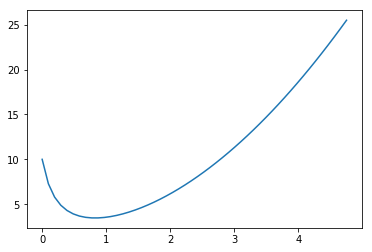

In [3]:
def model(x,t):
    return odefnt(x,t)

x0 = 10
t = np.linspace(0,4.75)
x = odeint(model,x0,t)
plt.plot(t,x)
plt.show()

Analytical solution using **odeint** which is an ode solver in python.

In [4]:
@jit
def sigma_xdot_se(u,v,w):
    return exp(-((v-u)**2)/(4*w**2))*sqrt(pi)*w

@jit
def cov_x_se(u,v,w):
    ans = pi*w**2*(v)*erf(v/(2*w)) \
    + 2*sqrt(pi)*w**3*exp(-(v**2)/(4*w**2)) \
    - pi*w**2*(u-v)*erf((u-v)/(2*w)) \
    - 2*sqrt(pi)*w**3*exp(-(u-v)**2/(4*w**2)) \
    + pi*w**2*v*erf(u/(2*w)) \
    + 2*sqrt(pi)*w**3*exp(-(u**2)/(4*w**2)) \
    - 2*sqrt(pi)*w**3;
    return ans
    #return integrate.dblquad(sigma_xdot, 0, t, lambda s: 0, lambda s: s)

@jit
def cov_xxdot_se(u,v,w):
    ans = pi*w**2*erf((u-v)/(2*w)) + pi*w**2*erf(v/(2*w))
    return ans
    #return integrate.quad(sigma_xdot, 0, s, args=t)

From the paper, $\Sigma_{0}^{\dot{x}}$, $\Sigma_{0}^{x}$ and $\Sigma_{0}^{x, \dot{x}}$ are of particular importance in the computation of the baysian solution to the differential equations. They are defined in terms of $R(u,v)$, $Q(u,v)$. We have: <br>

$\Sigma_{0}^{\dot{x}} = \alpha^{-1}\int R(u,z)R(v,z)dz$ <br>
$\Sigma_{0}^{x} = \alpha^{-1}\int Q(u,z)Q(v,z)dz$ <br>
$\Sigma_{0}^{x,\dot{x}} = \alpha^{-1}\int Q(u,z)R(v,z)dz$

In the square exponential kernel described in the paper we define:

$R(u,v) = e^{-\frac{(v-u)^2}{2\lambda^2}}$ <br>
$Q(u,v) =  \int\limits_0^u R(z,v) dz$

And solving $\Sigma_{0}^{\dot{x}}$, $\Sigma_{0}^{x}$ and $\Sigma_{0}^{x, \dot{x}}$, we have:

$\Sigma_{0}^{\dot{x}} = \alpha^{-1}\sqrt{\pi}\lambda e^{-\frac{-(v-u)^2}{4\lambda^2}}$ <br>
$\Sigma_{0}^{x} = \alpha^{-1}\cdot(\pi\lambda^2v\cdot erf(\frac{v}{2\lambda}) + 2\sqrt{\pi}\lambda^3e^{-\frac{v^2}{4\lambda^2}}
    - \pi\lambda^2(u-v)\cdot erf(\frac{u-v}{2\lambda}) - 2\sqrt{\pi}\lambda^3e^{-\frac{(u-v)^2}{4w^2}}
    + \pi\lambda^2u \cdot erf(\frac{u}{2\lambda}) + 2\sqrt{\pi}\lambda^3 e^{-\frac{u^2}{4\lambda^2}} - 2\sqrt{\pi}\lambda^3)$ <br>
$\Sigma_{0}^{x,\dot{x}} = \alpha^{-1}\cdot(\pi\lambda^2 \cdot erf(\frac{u-v}{2\lambda}) + \pi\lambda^2\cdot erf(\frac{v}{2\lambda}))$

In [23]:
@jit
def sigma_xdot_un(u,v,w):
    return (min(u,v)-max(u,v) + 2*w)*(min(u,v) - max(u,v) > -2*w)

@jit
def cov_x_un(u,v,w):
    ans =(4*w**2)*(min(u,v)-2*w)*(min(u,v)>(2*w)) \
    +(2*w)*((v+w)*min(u-w,v+w) - 0.5*min(u-w,v+w)**2 - (v+w)*max(w,v-w) + 0.5*max(w,v-w)**2)*(min(u-w,v+w)>max(w,v-w)) \
    +((1/3)*min(w,min(u-w,v-w))**3 + w*min(w,min(u-w,v-w))**2 + (w)**2*min(w,min(u-w,v-w))+(1/3)*(w)**3)*(min(w,min(u-w,v-w))>(-w)) \
    +(v)*(0.5*min(w,u-w)**2 + (w)*min(w,u-w)- 0.5*(v-w)**2 - (w)*(v-w))*(min(w,u-w)>(v-w)) \
    +(2*w)*((u+w)*min(u+w,v-w)-0.5*min(u+w,v-w)**2-(u+w)*max(w,u-w) + 0.5*max(w,u-w)**2)*(min(u+w,v-w)>max(w,u-w)) \
    +((u+w)*(v+w)*min(u+w,v+w) - 0.5*(u+v+2*w)*min(u+w,v+w)**2 + (1/3)*min(u+w,v+w)**3 - (u+w)*(v+w)*max(w,max(u-w,v-w)) + 0.5*(u+v+2*w)*max(w,max(u-w,v-w))**2 - (1/3)*max(w,max(u-w,v-w))**3)*(min(u,v)>max(0,max(u-2*w,v-2*w))) \
    +(u)*(0.5*min(w,v-w)**2 + (w)*min(w,v-w)- 0.5*(u-w)**2 - (w)*(u-w))*(min(w,v-w)>(u-w)) \
    +(u)*(v)*(2*w-max(u,v))*(2*w>max(u,v))

    return ans
    
@jit
def cov_xxdot_un(u,v,w):
    ans= (2*w)*(min(u-w,v+w) - max(w,v-w))*(min(u-w,v+w) > max(w,v-w)) \
    +(0.5*min(w,min(u-w,v+w))**2 + (w)*min(w,min(u-w,v+w)) - 0.5*(v-w)**2 -(w)*(v-w))*(min(w,min(u-w,v+w)) > (v-w)) \
    +((u+w)*min(u+w,v+w) - 0.5*min(u+w,v+w)**2 - (u+w)*max(w,max(u-w,v-w)) + 0.5*max(w,max(u-w,v-w))**2)*(min(u+w,v+w) > max(w,max(u-w,v-w))) \
    + (u)*(-max(u,v) + 2*w)*(-max(u,v) > -2*w)
    
    return ans

In the rectangle kernel case we have:

$\Sigma_{0}^{\dot{x}} = (min(u,v) - max(u,v) + 2\lambda) \cdot (min(u,v) - max(u,v) > -2\lambda)$
$
\begin{align}
\Sigma_{0}^{x} & =4\lambda^2(min(u,v)-2\lambda) \cdot (min(u,v)>2\lambda) \\
     &+2\lambda ((v+\lambda) \cdot min(u-\lambda,v+\lambda) - 0.5min(u-\lambda,v+\lambda)^2 - (v+\lambda) \cdot max(\lambda,v-\lambda) + 0.5max(\lambda,v-\lambda)^2) \cdot (min(u-\lambda,v+\lambda)>max(\lambda,v-\lambda)) \\
    &+(\frac{1}{3}min(\lambda,min(u-\lambda,v-\lambda))^3 + \lambda min(\lambda,min(u-\lambda,v-\lambda))^2 + \lambda^2 min(\lambda,min(u-\lambda,v-\lambda))+\frac{1}{3}\lambda^3)\cdot(min(\lambda,min(u-\lambda,v-\lambda))>-\lambda)  \\
    &+v(0.5min(\lambda,u-\lambda)^2 + \lambda min(\lambda,u-\lambda)- 0.5(v-\lambda)^2 - \lambda(v-\lambda)) \cdot (min(\lambda,u-\lambda)>(v-\lambda)) \\
    &+2\lambda((u+\lambda)\cdot min(u+\lambda,v-\lambda)-0.5min(u+\lambda,v-\lambda)^2-(u+\lambda)\cdot max(\lambda,u-\lambda) + 0.5max(\lambda,u-\lambda)^2) \cdot (min(u+\lambda,v-\lambda)>max(\lambda,u-\lambda)) \\
    &+((u+\lambda)\cdot(v+\lambda)\cdot min(u+\lambda,v+\lambda) - 0.5(u+v+2\lambda)\cdot min(u+\lambda,v+\lambda)^2 + \frac{1}{3}min(u+\lambda,v+\lambda)^3 - (u+\lambda)\cdot (v+\lambda) \cdot max(\lambda,max(u-\lambda,v-\lambda)) + 0.5(u+v+2\lambda) \cdot max(\lambda,max(u-\lambda,v-\lambda))^2 - \frac{1}{3}max(\lambda,max(u-\lambda,v-\lambda))^3)\cdot(min(u,v)>max(0,max(u-2\lambda,v-2\lambda))) \\
    &+u(0.5min(\lambda,v-\lambda)^2 + \lambda min(\lambda,v-\lambda)- 0.5(u-\lambda)^2 - \lambda(u-\lambda)) \cdot (min(\lambda,v-\lambda)>(u-\lambda)) \\
    &+uv(2\lambda-max(u,v)) \cdot (2\lambda>max(u,v))
\end{align}
$
$
\begin{align}
\Sigma_{0}^{x,\dot{x}} &= 2\lambda(min(u-\lambda,v+\lambda) - max(\lambda,v-\lambda)) \cdot (min(u-\lambda,v+\lambda) > max(\lambda,v-\lambda)) \\
    &+(0.5min(\lambda,min(u-\lambda,v+\lambda))^2 + \lambda min(\lambda,min(u-\lambda,v+\lambda)) - 0.5(v-\lambda)^2 -\lambda(v-\lambda)) \cdot (min(\lambda,min(u-\lambda,v+\lambda)) > (v-\lambda)) \\
    &+((u+\lambda) \cdot min(u+\lambda,v+\lambda) - 0.5min(u+\lambda,v+\lambda)^2 - (u+\lambda) \cdot max(\lambda,max(u-\lambda,v-\lambda)) + 0.5max(\lambda,max(u-\lambda,v-\lambda))^2)\cdot (min(u+\lambda,v+\lambda) > max(\lambda,max(u-\lambda,v-\lambda))) \\
    &+u(-max(u,v) + 2\lambda) \cdot (-max(u,v) > -2\lambda)
\end{align}
$

In [6]:
def R_se(u, v):
    return exp(-(v - u)**2/2)

def RR_se(z, u, v):
    return R_se(u,z)*R_se(v,z)

def Q_se(u,v):
    return sqrt(pi/2)*(erf(v/sqrt(2)) - erf((v-u)/sqrt(2)))

def QQ_se(z, u, v):
    return Q_se(u,z)*Q_se(v,z)

def QR_se(z, u, v):
    return Q_se(u,z)*R_se(v,z)

def sigma_xdot_se2(u,v):
    return integrate.quad(RR_se, -np.inf, np.inf, args=(u,v))

def cov_x_se2(u,v):
    return integrate.quad(QQ_se, -np.inf, np.inf, args=(u,v))

def cov_xxdot_se2(u,v):
    return integrate.quad(QR_se, -np.inf, np.inf, args=(u,v))

The above functions are used to verify that the derived equations for the square exponential case are indeed correct. 

In [18]:
if not np.testing.assert_approx_equal(sigma_xdot_se(1/4,1/4,1), sigma_xdot_se2(1/4,1/4)[0]) and \
    not np.testing.assert_approx_equal(cov_x_se(2,2,1), cov_x_se2(2,2)[0]) and \
    not np.testing.assert_approx_equal(cov_xxdot_se(3,3,1), cov_xxdot_se2(3,3)[0]):
        print(True)

True


In [24]:
def R_un(u, v):
    if v < u+1 and v > u-1:
        return 1
    else:
        return 0
    
def RR_un(z, u, v):
    return R_un(u,z)*R_un(v,z)

def Q_un(u, v):
    return max(0, min(v+1,u) - max(0, v-1))

    
def QQ_un(z, u, v):
    return Q_un(u,z)*Q_un(v,z)

def QR_un(z, u, v):
    return Q_un(u,z)*R_un(v,z)

def sigma_xdot_un2(u,v):
    return integrate.quad(RR_un, -np.inf, np.inf, args=(u,v))

def cov_x_un2(u,v):
    return integrate.quad(QQ_un, -1, max(u+1,v+1), args=(u,v))

def cov_xxdot_un2(u,v):
    return integrate.quad(QR_un, -np.inf, np.inf, args=(u,v))

The above functions are used to verify that the derived equations for the rectangular kernel case are indeed correct. 

In [25]:
if not np.testing.assert_approx_equal(sigma_xdot_un(1/4,1/4,1), sigma_xdot_un2(1/4,1/4)[0]) and \
    not np.testing.assert_approx_equal(cov_x_un(2,2,1), cov_x_un2(2,2)[0]) and \
    not np.testing.assert_approx_equal(cov_xxdot_un(3,3,1), cov_xxdot_un2(3,3)[0]):
        print(True)

True


In [21]:
#Comments below
def baysiansolver(N,a,b,u, kernel):
    t = np.linspace(a,b,N)
    w = (b-a)/(N-1)
    alpha = N/10

    mu_B = np.array([0]*N)
    mu_A = u + mu_B

    @jit
    def sigma_0(N,t,w,alpha):
        sigma_B = np.zeros((N, N))
        sigma_A = np.zeros((N, N))
        sigma_XB = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                if kernel == 'se':
                    sigma_B[i][j] = sigma_xdot_se(t[i], t[j], w)/alpha
                    sigma_A[i][j] = cov_x_se(t[i], t[j], w)/alpha
                    sigma_XB[i][j] = cov_xxdot_se(t[i], t[j], w)/alpha
                else:
                    sigma_B[i][j] = sigma_xdot_un(t[i], t[j], w)/alpha
                    sigma_A[i][j] = cov_x_un(t[i], t[j], w)/alpha
                    sigma_XB[i][j] = cov_xxdot_un(t[i], t[j], w)/alpha

        return sigma_B, sigma_A, sigma_XB
    sigma_B, sigma_A, sigma_XB = sigma_0(N,t,w,alpha)

    for i in range(N):
        A = np.random.normal(mu_A[i], sigma_A[i,i])
        B = odefnt(A, t[i])
        mu_A = mu_A + sigma_XB[:,i]*1/sigma_B[i,i] *(B - mu_B[i])
        mu_B = mu_B + sigma_B[:,i]*(B-mu_B[i])*1/sigma_B[i,i]
        sigma_A = sigma_A - 1/sigma_B[i,i]*np.outer(sigma_XB[:,i], sigma_XB[:,i])
        sigma_XB = sigma_XB - 1/sigma_B[i,i]*np.outer(sigma_XB[:,i], sigma_B[i,:])
        sigma_B = sigma_B - 1/sigma_B[i,i]*np.outer(sigma_B[:,i], sigma_B[i,:])
    
    return np.random.multivariate_normal(mu_A, sigma_A), mu_A, sigma_A, sigma_XB, sigma_B


**baysiansolver** takes in 5 arguments:

*N* is size of the discretization grid <br>
*a* is the lower bound of the range of the ode <br>
*b* is the upper bound of the range of the ode <br>
*u* is the initial value of the ode ($x(t_{0})=10$) <br>
*kernel* is the kernel used to define $R(u,v)$

**baysiansolver** outputs the solutions to the ode evaluated at each point in the discretization grid, as well as all the $\mu$ and $\Sigma$ used in the algorithm

Following the algorithm from the research paper, we start with a discretization grid s. w ($\lambda$ in the paper) and $\alpha$ are defined as suggested from their implementation in https://github.com/ochkrebtii/uqdes.

The algorithm initializes by defining mu_B to be $\vec{0}$ and mu_A to be $\vec{x(t_{0})}$ (a vector with elements all equal to the initial value, ie. 10 in our case). 
We define sigma_B ($\Sigma_{0}^B$) to be $\Sigma_{0}^{\dot{x}}$, sigma_A ($\Sigma_{0}^{A}$) to be $\Sigma_{0}^{x}$ and sigma_XB ($\Sigma_{0}^{XB}$) to be $\Sigma_{0}^{x,\dot{x}}$. Then using the above defined functions sigma_xdot_un, cov_x_un, and cov_xxdot_un we can initialize sigma_B, sigma_A and sigma_XB respectively. After initialization, the algorithm begins.

Algorithm:

$\tilde{A} \sim N(\mu_{n-1}^{A}(t_{n}), \Sigma_{n-1}^{A}(t_{n}))$ <br>
$\tilde{B} = f(t_{n}, \tilde{A})$ <br>
$\mu^{A}_{n} = \mu^{A}_{n-1} + \Sigma_{n-1}^{XB}(X(T), t_{n}) \cdot \Sigma_{n-1}^{B}(t_{n},t_{n})^{-1} \cdot (\tilde{B} - \mu_{n-1}^{B}(t_{n})) $ <br>
$\mu_{n}^B = \mu_{n-1}^B + \Sigma_{n-1}^B(X(T), t_{n}) \cdot \Sigma_{n-1}^B(t_{n},t_{n})^{-1} \cdot (\tilde{B}-\mu_{n-1}^B(t_{n}))$ <br>
$\Sigma_{n}^A = \Sigma_{n-1}^A - \Sigma_{n-1}^B(t_{n},t_{n})^{-1} \cdot \Sigma_{n-1}^{XB}(X(T), t_{n}) \Sigma_{n-1}^{XB}(X(T),t_{n})^{T} $ <br>
$\Sigma_{n}^{XB} = \Sigma_{n-1}^{XB} - \Sigma_{n-1}^B(t_{n},t_{n})^{-1} \cdot \Sigma_{n-1}^{XB}(X(T),t_{n}) \Sigma_{n-1}^B(t_{n},X(T))$ <br>
$\Sigma_{n}^B = \Sigma_{n-1}^B - \Sigma_{n-1}^B(t_{n},t_{n})^{-1} \cdot \Sigma_{n-1}^B(X(T),t_{n}) \Sigma_{n-1}^B(t_{n},X(T))$

C:\Users\mohan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: covariance is not positive-semidefinite.
C:\Users\mohan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: covariance is not positive-semidefinite.
C:\Users\mohan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: covariance is not positive-semidefinite.
C:\Users\mohan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: covariance is not positive-semidefinite.
C:\Users\mohan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: covariance is not positive-semidefinite.


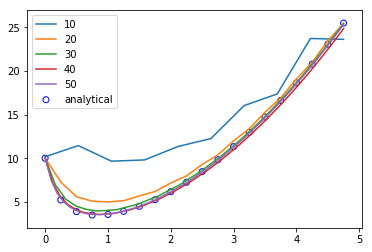

In [11]:
discretization_size = [10,20,30,40,50]
for d in discretization_size:
    u_all, mu_A, sigma_A, sigma_XB, sigma_B= baysiansolver(d, 0, 5-1/4, 10, 'se')
    t = np.linspace(0, 4.75, d)
    plt.plot(t,u_all, label = '{}'.format(d))
    plt.legend(loc='upper left')


x0 = 10
t = np.linspace(0,5-1/4, 20)
x = odeint(model,x0,t)
plt.scatter(t, x, facecolor = 'none', edgecolor = 'b', label='analytical')
plt.legend(loc='upper left')
plt.show()

This graph shows the solutions evaluated using the square exponential kernel.

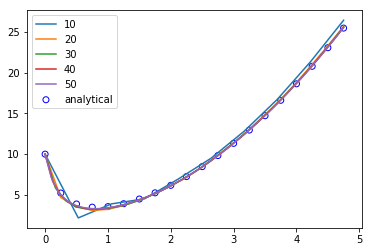

In [22]:
discretization_size = [10,20,30,40,50]
for d in discretization_size:
    u_all, mu_A, sigma_A, sigma_XB, sigma_B= baysiansolver(d, 0, 5-1/4, 10, 'u')
    t = np.linspace(0, 4.75, d)
    plt.plot(t,u_all, label = '{}'.format(d))
    plt.legend(loc='upper left')


x0 = 10
t = np.linspace(0,5-1/4, 20)
x = odeint(model,x0,t)
plt.scatter(t, x, facecolor = 'none', edgecolor = 'b', label='analytical')
plt.legend(loc='upper left')
plt.show()

This graph shows the solutions evaluated using the rectangular kernel.

In [13]:
def issparse(matrix):
    if np.count_nonzero(matrix)/(len(matrix)**2)< 0.5:
        return True
    return False

**issparse** checks if a matrix is a sparse matrix or not. 

In [14]:
print('sigma_B is sparse: {}'.format(issparse(sigma_B)))
print('sigma_XB is sparse: {}'.format(issparse(sigma_XB)))

sigma_B is sparse: True
sigma_XB is sparse: True


In [15]:
np.set_printoptions(edgeitems=len(sigma_B))
print(sigma_B)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.46944695e-18   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [16]:
print(sigma_XB)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -4.33680869e-19   0.00000000e+00   0.00000000e+00   0.00000000e+00
   -2.40741243e-35  -2.40741243e-35   9.81505029e-35 